# Random Forest Models for Customer Churn

In [42]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import seaborn as sns

df = pd.read_csv('bank_churn.csv')

print(df.head())

   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  


In [43]:
#check for missing values
df.isnull().sum()

encoder = LabelEncoder()
df = df.drop_duplicates()
df = df.drop(['customer_id'], axis=1)
df['country'] = encoder.fit_transform(df['country'])
df['gender'] = encoder.fit_transform(df['gender'])


In [44]:
X = df.drop(['churn'], axis=1) 

y = df['churn']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 48, stratify = y)

In [45]:
#scale data

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [46]:
#baseline random forest model
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=48)

rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)


print('Baseline rf model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Baseline rf model accuracy score with 100 decision-trees : 0.8523


In [47]:
feature_scores = pd.Series(rfc.feature_importances_, index=X_train_scaled_df.columns).sort_values(ascending=False)

# age and products_number are the most defining features
feature_scores

age                 0.435798
products_number     0.299031
active_member       0.110488
balance             0.052894
country             0.041748
credit_score        0.022661
gender              0.016249
estimated_salary    0.014480
tenure              0.005000
credit_card         0.001651
dtype: float64

The age range is from 18 to 92.
age_range
(30, 40]    4451
(40, 50]    2320
(17, 30]    1968
(50, 60]     797
(60, 70]     331
(70, 80]     121
(80, 92]      12
Name: count, dtype: int64


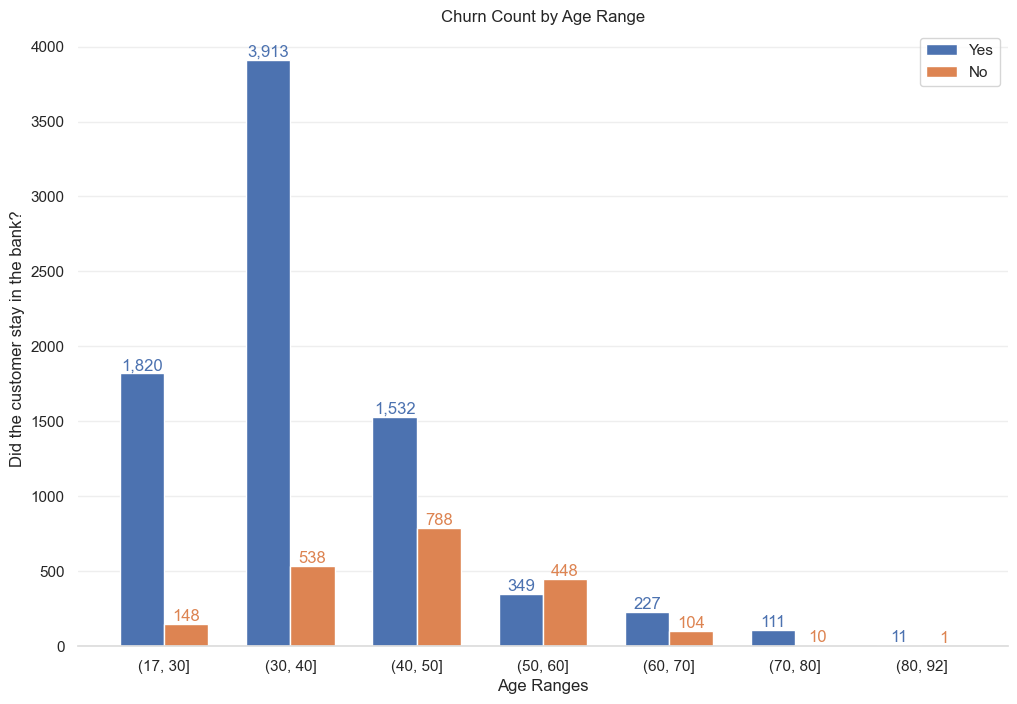

In [48]:
# Looking more into age as it's the highest correlate
min_age = df['age'].min()
max_age = df['age'].max()

print(f"The age range is from {min_age} to {max_age}.")

age_ranges = [17, 30, 40, 50, 60, 70, 80, 92]  
df['age_range'] = pd.cut(df['age'], bins=age_ranges)

df = df.sort_values(by="age_range")
print(df["age_range"].value_counts())

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35

x = np.arange(len(df.age_range.unique()))

b1 = ax.bar(x, df.loc[df['churn'] == 0, 'age_range'].value_counts().sort_index(), 
            width=bar_width)
b2 = ax.bar(x+bar_width, df.loc[df['churn'] == 1, 'age_range'].value_counts().sort_index(), 
            width=bar_width)

# fix x axis
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(df.age_range.unique())

# titling
ax.set_xlabel("Age Ranges")
ax.set_ylabel("Did the customer stay in the bank?")
ax.set_title("Churn Count by Age Range")

# add labeling 
for bar in ax.patches:
  bar_value = bar.get_height()
  text = f'{bar_value:,}'

  text_x = bar.get_x() + bar.get_width() / 2
  text_y = bar.get_y() + bar_value

  bar_color = bar.get_facecolor()
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color, size=12)

# axis styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.legend(['Yes','No'])
plt.show()

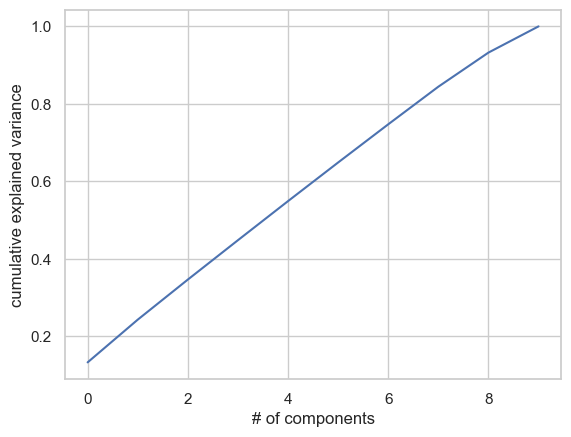

None

,Cumulative Variance Ratio
0,0.132219
1,0.242525
2,0.346044
3,0.447730
4,0.548686
5,0.648473
6,0.747052
7,0.844170
8,0.932253
9,1.000000


In [49]:
# Resuming back to rf model, continue with PCA
pca_test = PCA(n_components=10)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('# of components')
plt.ylabel('cumulative explained variance')
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)

pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr

display(pca_df.head(10))

# no need to reduce predicting variables

In [50]:
# find hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
max_features = [None, 'log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
criterion = ['gini', 'entropy']


param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'criterion': criterion}

rfc = RandomForestClassifier()

rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter=50, 
                        cv=3,
                        n_jobs = -1,
                        random_state = 48)

rs.fit(X_train_scaled, y_train)



RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 14, 18, 23, 27, 32,
                                                      36, 41, 45, 50],
                                        'max_features': [None, 'log2', 'sqrt'],
                                        'min_samples_leaf': [2, 7, 12, 18, 23,
                                                             28, 34, 39, 44,
                                                             50],
                                        'min_samples_split': [2, 7, 12, 18, 23,
                                                              28, 34, 39, 44,
                                                              50],
                                        'n_estimators': [100, 147, 194, 242,
                                                         289, 336, 384, 431,
                                                         478, 526, 573, 621,
                                                         668, 715, 763, 810,
                                                         857, 905, 952, 1000]},
                   random_state=48)

In [51]:
print('Best hyperparameters:',  rs.best_params_)
rs.best_estimator_ = RandomForestClassifier(random_state=48)
rs.best_estimator_.fit(X_train_scaled, y_train)
y_pred_tuned = rs.best_estimator_.predict(X_test_scaled)

print('Model accuracy after hyperparameter tuning: {0:0.4f}'. format(accuracy_score(y_test, y_pred_tuned)))

Best hyperparameters: {'n_estimators': 573, 'min_samples_split': 44, 'min_samples_leaf': 7, 'max_features': None, 'max_depth': 36, 'criterion': 'gini'}
Model accuracy after hyperparameter tuning: 0.8580


In [52]:
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                       index = ['actual stayed', 'actual left'], columns = ['predicted stayed', 'predicted left'])

conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_tuned), 
                    index = ['actual stayed', 'actual left'], columns = ['predicted stayed', 'predicted left'])


display(conf_matrix_baseline)
print('Baseline model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

display(conf_matrix_tuned)
print('Model accuracy after hyperparameter tuning: {0:0.4f}'. format(accuracy_score(y_test, y_pred_tuned)))

,predicted stayed,predicted left
actual stayed,2333,56
actual left,387,224


Baseline model accuracy score with 100 decision-trees : 0.8523


,predicted stayed,predicted left
actual stayed,2303,86
actual left,340,271


Model accuracy after hyperparameter tuning: 0.8580


# Conclusion

The tuned model demonstrates a slightly better performance in contrast to the baseline model. Of particular significance is that the tuned model is better at predicting if a customer is going to leave the bank, which is arguably the most important criteria we are looking for in this type of analysis. Overall, the model demonstrates promising capacity to guide our decision-making processes regarding customer retention.

A first step of action can be to look into why a higher proportion of customers middle-aged and above (41+) churn. One possible explanation could be because of technology adaptation: as we move towards digital banking and online services, older customers may be uncomfortable dealing with technology and seek more familiar alternatives. Going forward, we have to pay special attention to our older customers and ensure they have the necessary user-friendly resources to facilitate a satisfactory banking experience with us.


# Future Direction

To make a more thorough model, we can generate more random forests by increasing the number of iterations and cross-validations.
From there, we can identify the values of hyperparamters that created the most successful models on average. 
After that, we use these specific hyperparameters to continue with a second round of hyperparameter tuning using GridSearchCV. GridSearchCV would then perform every combination of the hyperparameter values we gave it and return the model with the best hyperparameters. However, going through these steps take a lot more computation power. This project was made to be run-time friendly, and so these steps were not taken here.